In [106]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [15]:
files = [f for f in os.listdir("./demand_dump/halfhours/") if f[-3:] == "zip"]
files[:5]

['PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_201801261730_20180126173118.zip',
 'PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_201804200130_20180420013107.zip',
 'PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_201806062100_20180606210123.zip',
 'PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_201806022000_20180602200104.zip',
 'PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_201807300000_20180730000107.zip']

In [27]:
files = sorted(files)
files[:10]

['PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_201712240000_20171224000051.zip',
 'PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_201712240030_20171224003022.zip',
 'PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_201712240100_20171224010116.zip',
 'PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_201712240130_20171224013047.zip',
 'PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_201712240200_20171224020019.zip',
 'PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_201712240230_20171224023114.zip',
 'PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_201712240300_20171224030044.zip',
 'PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_201712240330_20171224033015.zip',
 'PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_201712240400_20171224040111.zip',
 'PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_201712240430_20171224043043.zip']

In [74]:
len(files)

18555

In [17]:
#     try:
#         f1 = "AEMO-datadump/PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_20171224/" + file
# df1 = pd.read_csv(f"./demand_dump/halfhours/{files[0]}")
# df1.columns = list(df1.columns)[:4] + list(df1.iloc[0,4:8]) + list(df1.columns[8:])
# df1.drop(index=0, inplace=True)
#     except:
#         print(file)
df1

,C,NEMP.WORLD,ACTUAL_OPERATIONAL_DEMAND_HH,AEMO,REGIONID,INTERVAL_DATETIME,OPERATIONAL_DEMAND,LASTCHANGED,DEMAND,0000000295813169.1
1,D,OPERATIONAL_DEMAND,ACTUAL,1.0,NSW1,2018/06/14 12:30:00,8329,2018/06/14 12:31:00,NaN,NaN
2,D,OPERATIONAL_DEMAND,ACTUAL,1.0,QLD1,2018/06/14 12:30:00,5820,2018/06/14 12:31:00,NaN,NaN
3,D,OPERATIONAL_DEMAND,ACTUAL,1.0,SA1,2018/06/14 12:30:00,1414,2018/06/14 12:31:00,NaN,NaN
4,D,OPERATIONAL_DEMAND,ACTUAL,1.0,TAS1,2018/06/14 12:30:00,1267,2018/06/14 12:31:00,NaN,NaN
5,D,OPERATIONAL_DEMAND,ACTUAL,1.0,VIC1,2018/06/14 12:30:00,5680,2018/06/14 12:31:00,NaN,NaN
6,C,END OF REPORT,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<font color = "purple"><font size = 5>
    New try with better processing and including ISSUED timestamp

In [64]:
%%time
day_df = pd.DataFrame(index=["NSW1","QLD1","SA1","TAS1","VIC1","ISSUED"])
dup_df = pd.DataFrame(index=["NSW1","QLD1","SA1","TAS1","VIC1","ISSUED"])
failed_list = []
for file in files:
    try:
        df1 = pd.read_csv(f"./demand_dump/halfhours/{file}")
        df1.loc[6,'PUBLIC'] = "ISSUED"
        issued = pd.to_datetime(df1.columns[5] + " " + df1.columns[6])
        df1.columns = list(df1.columns)[:4] + list(df1.iloc[0,4:8]) + list(df1.columns[8:])
        df1.drop(index=0, inplace=True)
        df1.OPERATIONAL_DEMAND = df1.OPERATIONAL_DEMAND.astype(float)
        df1.loc[6,"OPERATIONAL_DEMAND"] = issued
        dem_df1 = pd.DataFrame(data = df1.loc[1:6,"OPERATIONAL_DEMAND"].values, index = df1.loc[1:6,"REGIONID"],columns=[pd.to_datetime(df1.loc[1,"INTERVAL_DATETIME"])])
        
        this_timestamp = dem_df1.columns[0]
        if (this_timestamp in day_df.columns) and (dem_df1.iloc[0,5] > day_df.loc["ISSUED",this_timestamp]):
            dup_df = pd.merge(dup_df,day_df[this_timestamp], how='outer').merge(dem_df1, how='outer')  ## keep record of different ones
            day_df[dem_df1.columns[0]] = dem_df1                  ## assume most recent is most correct
        elif (this_timestamp in day_df.columns) and (dem_df1.iloc[0,5] <= day_df.loc["ISSUED",this_timestamp]):
            dup_df = pd.merge(dup_df,day_df[this_timestamp], how='outer').merge(dem_df1, how='outer')  ## keep record, assume if an earlier version then ignore, keep original
        else:
            day_df = pd.merge(day_df, dem_df1, left_index=True, right_index=True)  ## otherwise go ahead and merge

    except:
        failed_list.append(file)

day_df.to_csv("day_df_t3_all.csv", sep="\t")


CPU times: user 48min 56s, sys: 28.1 s, total: 49min 24s
Wall time: 51min 52s


In [65]:
day_df

,2017-12-24 00:00:00,2017-12-24 00:30:00,2017-12-24 01:00:00,2017-12-24 01:30:00,2017-12-24 02:00:00,2017-12-24 02:30:00,2017-12-24 03:00:00,2017-12-24 03:30:00,2017-12-24 04:00:00,2017-12-24 04:30:00,...,2019-01-19 19:00:00,2019-01-19 19:30:00,2019-01-19 20:00:00,2019-01-19 20:30:00,2019-01-19 21:00:00,2019-01-19 21:30:00,2019-01-19 22:00:00,2019-01-19 22:30:00,2019-01-19 23:00:00,2019-01-19 23:30:00
REGIONID,,,,,,,,,,,,,,,,,,,,,
NSW1,7255,7028,6805,6513,6301,6184,6113,6060,6038,6087,...,8909,8833,8788,8641,8458,8281,8176,8041,7849,7689
QLD1,6198,5977,5805,5696,5587,5534,5515,5464,5429,5417,...,8032,8060,8010,7821,7568,7399,7196,7034,6879,6642
SA1,1580,1513,1448,1358,1310,1281,1263,1230,1208,1204,...,1517,1526,1520,1515,1503,1463,1437,1396,1367,1352
TAS1,1070,1075,1066,1066,1060,1063,1063,1061,1060,1065,...,1168,1156,1153,1174,1175,1163,1096,1019,1000,998
VIC1,4630,4433,4286,4159,4010,3886,3828,3789,3767,3793,...,4960,4897,4835,4834,4761,4658,4544,4459,4390,4547
ISSUED,2017-12-24 00:00:51,2017-12-24 00:30:22,2017-12-24 01:01:16,2017-12-24 01:30:47,2017-12-24 02:00:19,2017-12-24 02:31:14,2017-12-24 03:00:44,2017-12-24 03:30:15,2017-12-24 04:01:11,2017-12-24 04:30:43,...,2019-01-19 19:00:31,2019-01-19 19:30:07,2019-01-19 20:01:06,2019-01-19 20:30:42,2019-01-19 21:00:17,2019-01-19 21:31:17,2019-01-19 22:00:51,2019-01-19 22:30:25,2019-01-19 23:01:25,2019-01-19 23:31:00


In [71]:
print(len(failed_list))
failed_list[:5]

75


['PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_201806140030_20180614161132.zip',
 'PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_201806140100_20180614161132.zip',
 'PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_201806140130_20180614161132.zip',
 'PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_201806140200_20180614161132.zip',
 'PUBLIC_ACTUAL_OPERATIONAL_DEMAND_HH_201806140230_20180614161132.zip']

In [69]:
dicfailed = {k:v for k,v in zip(files,[files.index(f) for f in failed_list])}

In [75]:
tdf = day_df.T
tdf.head()

REGIONID,NSW1,QLD1,SA1,TAS1,VIC1,ISSUED
2017-12-24 00:00:00,7255,6198,1580,1070,4630,2017-12-24 00:00:51
2017-12-24 00:30:00,7028,5977,1513,1075,4433,2017-12-24 00:30:22
2017-12-24 01:00:00,6805,5805,1448,1066,4286,2017-12-24 01:01:16
2017-12-24 01:30:00,6513,5696,1358,1066,4159,2017-12-24 01:30:47
2017-12-24 02:00:00,6301,5587,1310,1060,4010,2017-12-24 02:00:19


In [80]:
tdf.sort_index(inplace=True)
tdf.tail()

REGIONID,NSW1,QLD1,SA1,TAS1,VIC1,ISSUED
2019-01-19 21:30:00,8281,7399,1463,1163,4658,2019-01-19 21:31:17
2019-01-19 22:00:00,8176,7196,1437,1096,4544,2019-01-19 22:00:51
2019-01-19 22:30:00,8041,7034,1396,1019,4459,2019-01-19 22:30:25
2019-01-19 23:00:00,7849,6879,1367,1000,4390,2019-01-19 23:01:25
2019-01-19 23:30:00,7689,6642,1352,998,4547,2019-01-19 23:31:00


In [90]:
tdf.to_csv("Tdf_demand_20171224-2018119.csv")

In [82]:
fulldtrange = pd.date_range(start='2017-12-24 00:00:00', end='2019-01-19 23:30:00', freq='30min')

In [83]:
missing = [dts for dts in fulldtrange if dts not in tdf.index]
print(len(missing))
missing[:10]

336


[Timestamp('2018-09-02 00:00:00', freq='30T'),
 Timestamp('2018-09-02 00:30:00', freq='30T'),
 Timestamp('2018-09-02 01:00:00', freq='30T'),
 Timestamp('2018-09-02 01:30:00', freq='30T'),
 Timestamp('2018-09-02 02:00:00', freq='30T'),
 Timestamp('2018-09-02 02:30:00', freq='30T'),
 Timestamp('2018-09-02 03:00:00', freq='30T'),
 Timestamp('2018-09-02 03:30:00', freq='30T'),
 Timestamp('2018-09-02 04:00:00', freq='30T'),
 Timestamp('2018-09-02 04:30:00', freq='30T')]

In [89]:
set(dt.date() for dt in missing)
#     print(dt.date())

{datetime.date(2018, 9, 2),
 datetime.date(2018, 9, 3),
 datetime.date(2018, 9, 4),
 datetime.date(2018, 9, 5),
 datetime.date(2018, 9, 6),
 datetime.date(2018, 9, 7),
 datetime.date(2018, 9, 8)}

In [96]:
tdf.shape

(18480, 6)

In [97]:
ftdf = pd.merge(pd.DataFrame(index=fulldtrange), tdf.iloc[:,:5], how='outer', left_index=True, right_index=True)
ftdf.head()

,NSW1,QLD1,SA1,TAS1,VIC1
2017-12-24 00:00:00,7255,6198,1580,1070,4630
2017-12-24 00:30:00,7028,5977,1513,1075,4433
2017-12-24 01:00:00,6805,5805,1448,1066,4286
2017-12-24 01:30:00,6513,5696,1358,1066,4159
2017-12-24 02:00:00,6301,5587,1310,1060,4010


In [100]:
ftdf["NEMtotal"] = ftdf.iloc[:,:5].sum(axis=1)
ftdf.head()

,NSW1,QLD1,SA1,TAS1,VIC1,NEMtotal
2017-12-24 00:00:00,7255,6198,1580,1070,4630,20733.0
2017-12-24 00:30:00,7028,5977,1513,1075,4433,20026.0
2017-12-24 01:00:00,6805,5805,1448,1066,4286,19410.0
2017-12-24 01:30:00,6513,5696,1358,1066,4159,18792.0
2017-12-24 02:00:00,6301,5587,1310,1060,4010,18268.0


In [104]:
ftdf = ftdf.merge(tdf[["ISSUED"]], how='outer', right_index=True, left_index=True)
ftdf.head()

,NSW1,QLD1,SA1,TAS1,VIC1,NEMtotal,ISSUED
2017-12-24 00:00:00,7255,6198,1580,1070,4630,20733.0,2017-12-24 00:00:51
2017-12-24 00:30:00,7028,5977,1513,1075,4433,20026.0,2017-12-24 00:30:22
2017-12-24 01:00:00,6805,5805,1448,1066,4286,19410.0,2017-12-24 01:01:16
2017-12-24 01:30:00,6513,5696,1358,1066,4159,18792.0,2017-12-24 01:30:47
2017-12-24 02:00:00,6301,5587,1310,1060,4010,18268.0,2017-12-24 02:00:19


In [105]:
ftdf.to_csv("Tdf-NEMtotal_demand_20171224-2018119.csv")

TypeError: invalid type promotion

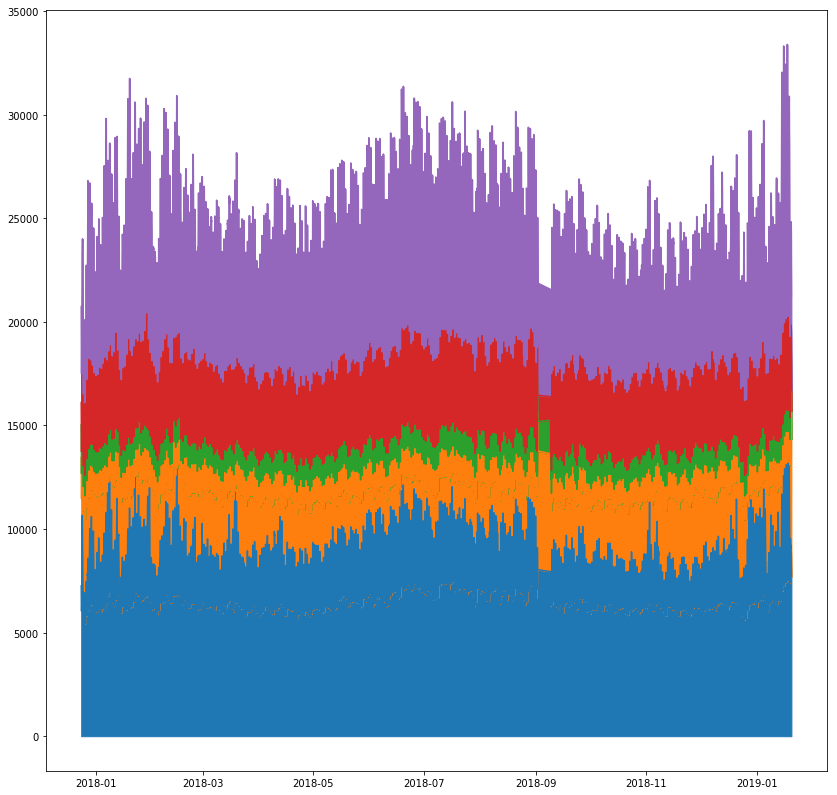

In [79]:
# tdf = day_df.T
tdf.plot.area(figsize = (14,14))
plt.show()

In [ ]:
tdf.NSW1

In [78]:
tdf.shape

(18480, 6)

In [ ]:
fig1, ax1 = plt.subplots(figsize = (12,12))

# ax1.scatter(x=tdf.index, y=tdf.NSW1)
ax1.plot(x=tdf.NSW1.index, y=tdf.NSW1.values)
ax1.set_xlim(left = pd.to_datetime("2017-12-24 0:00"), right = pd.to_datetime("2017-12-31 0:00"))
ax1.set_ylim(bottom=0, top=30000)